In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")


In [5]:
# Load data
data = pd.read_csv('call_center_data_example.csv', parse_dates=['date'], index_col='date')
data = data.sort_index()

In [6]:
data.head()

,calls,missed_calls,avg_call_duration,employees,absentees,day_of_week,holiday,active_customers,promo_active
date,,,,,,,,,
2024-01-01,150,20,5.3,10,1,Monday,Yes,5000,No
2024-01-02,180,25,6.0,12,0,Tuesday,No,5010,Yes
2024-01-03,170,22,5.8,11,1,Wednesday,No,5020,No
2024-01-04,160,18,5.5,10,2,Thursday,No,5030,No
2024-01-05,200,30,6.2,12,0,Friday,No,5040,Yes


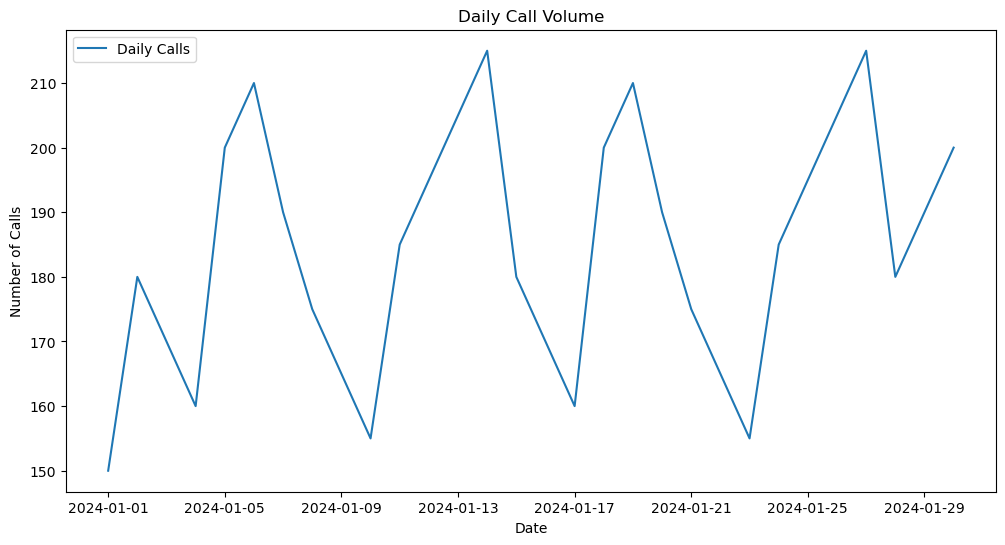

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(data['calls'], label='Daily Calls')
plt.title('Daily Call Volume')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.legend()
plt.show()

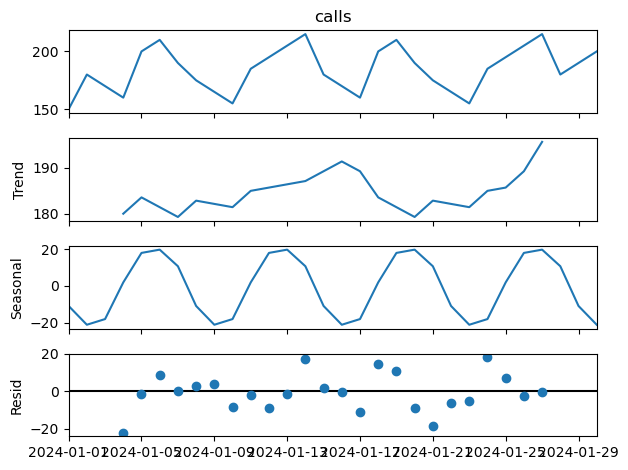

In [8]:
# Decompose the time series
decomposition = seasonal_decompose(data['calls'], model='additive', period=7)
decomposition.plot()
plt.show()

In [9]:
# Stationarity test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] > 0.05:
        print("The series is not stationary.")
    else:
        print("The series is stationary.")


In [11]:
adf_test(data['calls'])

ADF Statistic: -4.094825932786458
p-value: 0.0009877739857607783
Critical Values: {'1%': -3.6996079738860943, '5%': -2.9764303469999494, '10%': -2.627601001371742}
The series is stationary.


In [13]:
# Differencing to make the data stationary if needed
data['calls_diff'] = data['calls'].diff().dropna()
adf_test(data['calls_diff'].dropna())

ADF Statistic: -6.144038227814613
p-value: 7.845389583661776e-08
Critical Values: {'1%': -3.7238633119999998, '5%': -2.98648896, '10%': -2.6328004}
The series is stationary.


In [14]:
# Train-Test Split
train = data[:int(0.8 * len(data))]
test = data[int(0.8 * len(data)):]  

In [15]:
# SARIMA Model
def train_sarima(train, test, order, seasonal_order):
    model = SARIMAX(train['calls'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    sarima_fit = model.fit(disp=False)
    
    # Forecast
    forecast = sarima_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)
    
    # Metrics
    mae = mean_absolute_error(test['calls'], forecast)
    rmse = np.sqrt(mean_squared_error(test['calls'], forecast))
    print(f"MAE: {mae}, RMSE: {rmse}")
    
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(train['calls'], label='Train Data')
    plt.plot(test['calls'], label='Test Data')
    plt.plot(forecast, label='Forecast', linestyle='--')
    plt.title('SARIMA Forecast')
    plt.xlabel('Date')
    plt.ylabel('Number of Calls')
    plt.legend()
    plt.show()
    
    return sarima_fit, forecast

MAE: 19.407181091265613, RMSE: 22.832024493598976


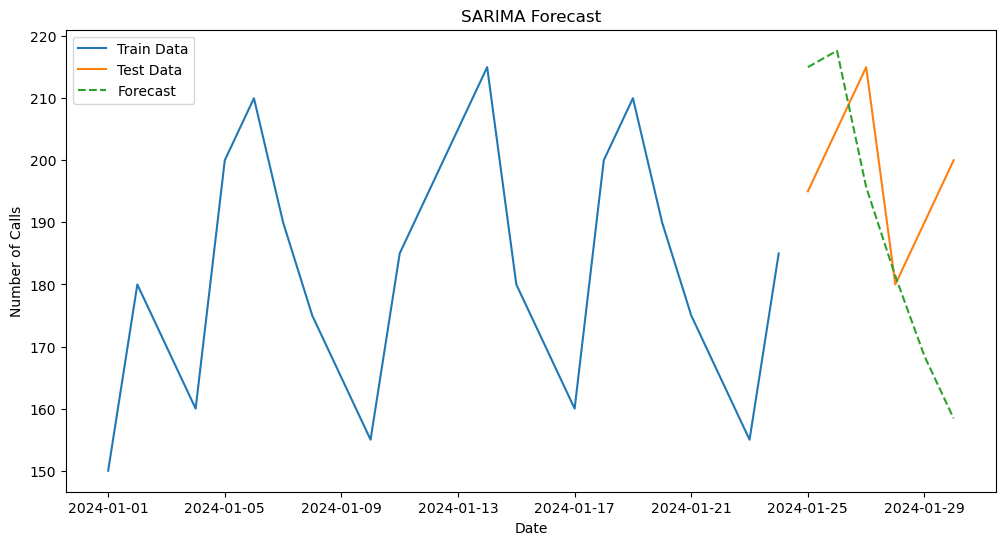

In [16]:
# Example SARIMA Parameters
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)  # Weekly seasonality

sarima_model, forecast = train_sarima(train, test, order, seasonal_order)

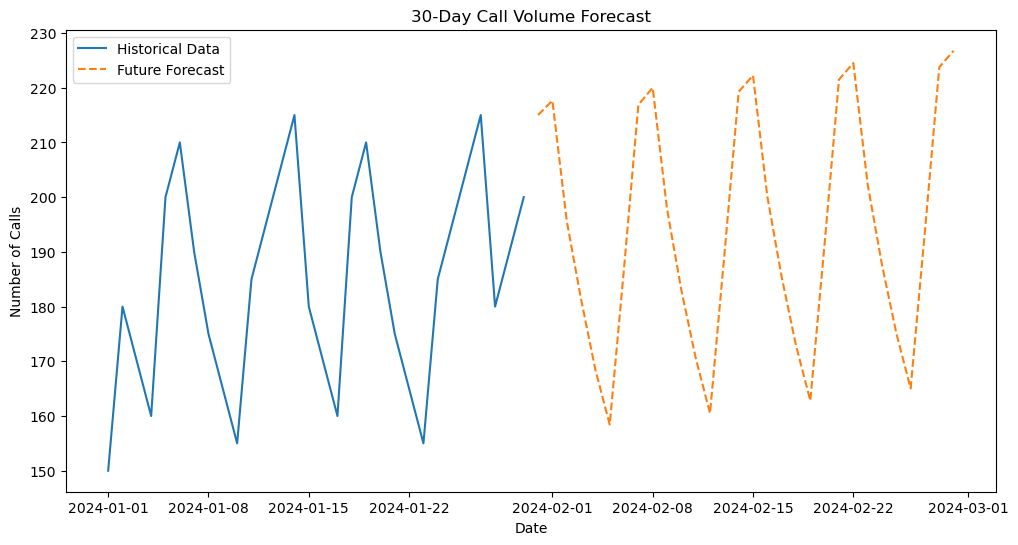

In [17]:
# Future Forecast
future_steps = 30
future_forecast = sarima_model.get_forecast(steps=future_steps)
future_index = pd.date_range(start=data.index[-1], periods=future_steps + 1, freq='D')[1:]
future_forecast_mean = future_forecast.predicted_mean

plt.figure(figsize=(12, 6))
plt.plot(data['calls'], label='Historical Data')
plt.plot(future_index, future_forecast_mean, label='Future Forecast', linestyle='--')
plt.title('30-Day Call Volume Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.legend()
plt.show()

In [18]:
# Save the results
future_forecast_mean.to_csv('forecasted_calls.csv', index=True)